# Handwritten greek characters classification

In [1]:
import os
import random
import itertools

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

ModuleNotFoundError: No module named 'cv2'

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

NameError: name 'tf' is not defined

In [3]:
print('Tensorflow version : {}'.format(tf.__version__))
print('GPU : {}'.format(tf.config.list_physical_devices('GPU')))

Tensorflow version : 2.9.1
GPU : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
DATASET_FOLDER = "dataset"
CATEGORIES = os.listdir(DATASET_FOLDER)
N_CATEGORIES = len(CATEGORIES)
IMG_SIZE = 32 # image size will be 32x32
BATCH_SIZE = 32
EPOCHS = 100
early_stopping_patience = 10
stps_per_epoch_factor = 1

## Dataset

In [5]:
for category in CATEGORIES:
    class_num = CATEGORIES.index(category)
print(CATEGORIES[4])
print("Number of categories: ", N_CATEGORIES)

CAP_PII
Number of categories:  48


In [6]:
def get_label_name(label):
    return CATEGORIES[label]

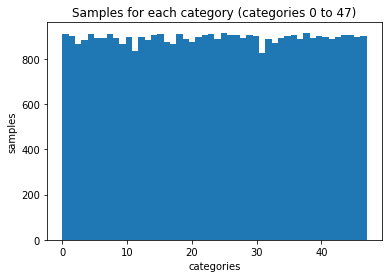

In [7]:
# plotting histogram of distribution of classes
labels = []
for category in CATEGORIES:
    path = os.path.join(DATASET_FOLDER, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        labels.append(class_num)
plt.hist(labels, bins = N_CATEGORIES)
plt.title("Samples for each category (categories 0 to 47)")
plt.xlabel("categories")
plt.ylabel("samples")
plt.show()

In [7]:
images = []
labels = []
for category in CATEGORIES:
    path = os.path.join(DATASET_FOLDER, category)
    class_num = CATEGORIES.index(category)
    print("Reading ", category, " num ", class_num+1, end=" :: ")
    for img in os.listdir(path):
        img = os.path.join(path, img)
        img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        # normalizing image and converting to floating point values
        mean_px = img.mean().astype(np.float32)
        std_px = img.std().astype(np.float32)
        img = ( img - mean_px ) / std_px
        images.append(img)
        labels.append(class_num)
images = tf.constant(images)
labels = tf.constant(labels)
# converting to one-hot encoding
labels = to_categorical(labels)

Reading  SML_THETA  num  1 :: Reading  CAP_EPSILON  num  2 :: Reading  SML_YPSILON  num  3 :: Reading  CAP_YPSILON  num  4 :: Reading  CAP_PII  num  5 :: Reading  CAP_OMEGA  num  6 :: Reading  SML_XI  num  7 :: Reading  SML_ZETA  num  8 :: Reading  CAP_OMIKRON  num  9 :: Reading  SML_OMIKRON  num  10 :: Reading  CAP_LAMDA  num  11 :: Reading  SML_IOTA  num  12 :: Reading  CAP_PSI  num  13 :: Reading  CAP_GAMMA  num  14 :: Reading  CAP_ZETA  num  15 :: Reading  CAP_ALPHA  num  16 :: Reading  CAP_TAU  num  17 :: Reading  SML_NI  num  18 :: Reading  SML_LAMDA  num  19 :: Reading  SML_KAPA  num  20 :: Reading  SML_TAU  num  21 :: Reading  SML_PII  num  22 :: Reading  SML_DELTA  num  23 :: Reading  SML_KSI  num  24 :: Reading  SML_HETA  num  25 :: Reading  CAP_DELTA  num  26 :: Reading  CAP_THETA  num  27 :: Reading  SML_BETA  num  28 :: Reading  CAP_XI  num  29 :: Reading  SML_FI  num  30 :: Reading  CAP_HETA  num  31 :: Reading  CAP_KSI  num  32 :: Reading  SML_OMEGA  num  33 :: Reading  

2022-07-11 15:22:34.723083: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 175845376 exceeds 10% of free system memory.


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
34
CAP_KAPA


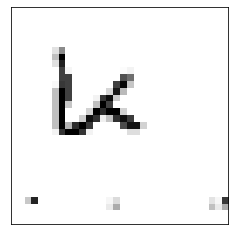

In [8]:
# visualizing an example
i = 31000
print(labels[i])
indx = np.where(labels[i]==1)[0][0]
print(indx)
print(get_label_name(indx))
plt.imshow(images[i],cmap="gray")
plt.xticks([])
plt.yticks([])
plt.show()

In [9]:
def _parse_function(image, label):
    #image = tf.cast(image, tf.float32) # no need to cast, already done
    # this is because Conv2D layers need (batch_size, width, height, channels) shape
    image = tf.reshape(image, (IMG_SIZE,IMG_SIZE,1))
    return image, label

In [10]:
def _augmentation(images, label):
    aug_layers = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.05),
        tf.keras.layers.RandomZoom(0.1, fill_mode="nearest"),
        tf.keras.layers.RandomTranslation(0.1, 0.1, fill_mode="nearest")
    ])
    # add training=True parameter to show batch images when not in training
    aug_imgs = aug_layers(images)
    return aug_imgs, label

In [11]:
# dataset size
DATASET_SIZE = len(images)
train_dataset_size = int(DATASET_SIZE * 0.70)
val_dataset_size = int(DATASET_SIZE * 0.15)
test_dataset_size = int(DATASET_SIZE * 0.15)
print("Dataset size: ", DATASET_SIZE)
print("Train dataset size: ", train_dataset_size)
print("Validation dataset size: ", val_dataset_size)
print("Test dataset size: ", test_dataset_size)

Dataset size:  42931
Train dataset size:  30051
Validation dataset size:  6439
Test dataset size:  6439


In [12]:
def create_dataset(augmentation=True):
    # creating dataset
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    # important to shuffle without reshuffling each iteration so that train, dev and test set can be created correctly
    dataset = dataset.shuffle(DATASET_SIZE, reshuffle_each_iteration=False)

    # dividing in train, dev and test set
    train_dataset = dataset.take(train_dataset_size)
    test_dataset = dataset.skip(train_dataset_size)
    val_dataset = test_dataset.skip(test_dataset_size)
    test_dataset = test_dataset.take(test_dataset_size)

    # dataset augmentation and repeat
    # train dataset shuffles once again, this time reshuffling for each iteration
    train_dataset = train_dataset.shuffle(train_dataset_size)
    if(augmentation):
        train_dataset = train_dataset.map(_augmentation, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    
    # batches
    train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
    val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
    test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)    
    
    train_dataset = train_dataset.repeat()
    val_dataset = val_dataset.repeat()
    test_dataset = test_dataset.repeat()
    
    return train_dataset, val_dataset, test_dataset

In [13]:
def look_at_batch(dataset_p):
    print(type(dataset_p))
    for batch in dataset_p:
        print(type(batch))
        #print(batch[0])
        print(batch[0].shape)
        #print(batch[1])
        print(batch[1].shape)
        fig = plt.figure(figsize=(10,10))
        rows = 4
        cols = 8
        for i in range(BATCH_SIZE):
            fig.add_subplot(rows, cols, i+1)
            plt.imshow(batch[0][i],cmap="gray")
            indx = np.where(batch[1][i]==1)[0][0]
            plt.xlabel(CATEGORIES[indx],size="small")
            plt.xticks([])
            plt.yticks([])
        #plt.imshow(batch[0],cmap="gray")
        #plt.show()
        #print(CATEGORIES[batch[1]])
        plt.show()
        break

In [14]:
train_dataset, val_dataset, test_dataset = create_dataset()

2022-07-11 15:22:40.847317: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 175845376 exceeds 10% of free system memory.


<class 'tensorflow.python.data.ops.dataset_ops.RepeatDataset'>


2022-07-11 15:22:42.897409: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 175845376 exceeds 10% of free system memory.


<class 'tuple'>
(32, 32, 32, 1)
(32, 48)


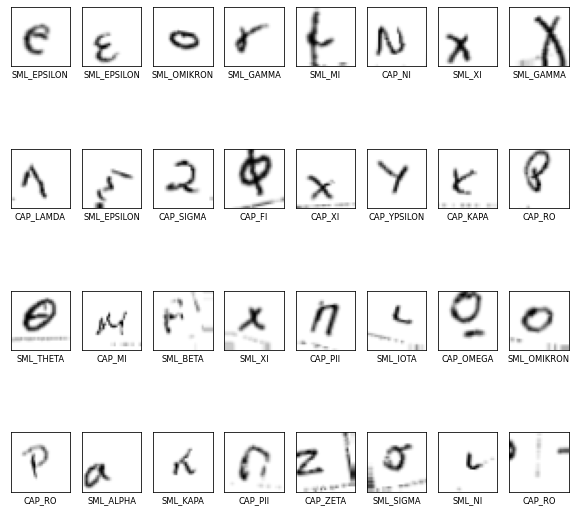

In [15]:
# looking at a batch
look_at_batch(train_dataset)

## Models

In [16]:
early_stopping = EarlyStopping(monitor = "val_accuracy", patience = early_stopping_patience, restore_best_weights = True)
# variable learning rate for BetterLeNet5
variable_learning_rate = ReduceLROnPlateau(monitor = "val_loss", factor = 0.2, patience = 2)

In [17]:
def ANN(input_shape_p = (32, 32, 1), classes = 48):
    model = Sequential([
        Flatten(input_shape = input_shape_p, name = "flatten"),
        Dense(units = 1440, activation = "relu", name = "fully_connected_1"),
        Dense(units = classes, activation = "softmax", name = "output"),
    ])
    model._name = "ANN"
    return model

In [18]:
# the model
def LeNet5(input_shape_p = (32, 32, 1), classes = 48):
    model = Sequential([
        # layer 1 -- convolutional layer
        Conv2D(filters = 6, kernel_size = 5, strides = 1, activation = "relu", input_shape = input_shape_p, name = "convolution_1"),
        MaxPooling2D(pool_size = 2, strides = 2, name = "max_pool_1"),
        # layer 2 -- convolutional layer
        Conv2D(filters = 16, kernel_size = 5, strides = 1, activation = "relu", name = "convolution_2"),
        MaxPooling2D(pool_size = 2, strides = 2, name = "max_pool_2"),
        # layer 3 -- fully connected layer
        Flatten(name = "flatten"),
        Dense(units = 120, activation = "relu", name = "fully_connected_1"),
        # layer 4 -- fully connected layer
        Dense(units = 84, activation = "relu", name = "fully_connected_2"),
        # layer 5 -- output
        Dense(units = classes, activation = "softmax", name = "output")
    ])
    model._name = "LeNet5"
    return model

In [19]:
def BetterLeNet5(input_shape_p = (32, 32, 1), classes = 48):
    model = Sequential([
        Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = "relu", input_shape = input_shape_p, kernel_regularizer = l2(0.0005), name = "convolution_1"),
        Conv2D(filters = 32, kernel_size = 5, strides = 1, name = "convolution_2", use_bias = False),
        BatchNormalization(name = "batchnorm_1"),
        #
        Activation("relu"),
        MaxPooling2D(pool_size = 2, strides = 2, name = "max_pool_1"),
        Dropout(0.25, name = "dropout_1"),
        #
        Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = "relu", kernel_regularizer = l2(0.0005), name = "convolution_3"),
        Conv2D(filters = 64, kernel_size = 3, strides = 1, name = "convolution_4", use_bias = False),
        BatchNormalization(name = "batchnorm_2"),
        #
        Activation("relu"),
        MaxPooling2D(pool_size = 2, strides = 2, name = "max_pool_2"),
        Dropout(0.25, name = "dropout_2"),
        Flatten(name = "flatten"),
        #
        Dense(units = 256, name = "fully_connected_1", use_bias = False),
        BatchNormalization(name = "batchnorm_3"),
        Activation("relu"),
        #
        Dense(units = 128, name = "fully_connected_2", use_bias = False),
        BatchNormalization(name = "batchnorm_4"),
        Activation("relu"),
        #
        Dense(units = 84, name = "fully_connected_3", use_bias = False),
        BatchNormalization(name = "batchnorm_5"),
        Activation("relu"),
        Dropout(0.25, name = "dropout_3"),
        #
        Dense(units = classes, activation = "softmax", name = "output")
    ])
    model._name = "BetterLeNet5"
    return model

In [20]:
DROPOUT = 0.25
# removed regularizer   , kernel_regularizer = l2(0.0005) from Conv2D layers
def LeNet5v2(input_shape_p = (32, 32, 1), classes = 48):
    model = Sequential([
        Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = "relu", input_shape = input_shape_p, kernel_regularizer = l2(0.0005), name = "convolution_1"),
        Conv2D(filters = 32, kernel_size = 5, strides = 1, name = "convolution_2", use_bias = False),
        BatchNormalization(name = "batchnorm_1"),
        #
        Activation("relu"),
        MaxPooling2D(pool_size = 2, strides = 2, name = "max_pool_1"),
        Dropout(DROPOUT, name = "dropout_1"),
        #
        
        Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = "relu", kernel_regularizer = l2(0.0005), name = "convolution_3"),
        Conv2D(filters = 64, kernel_size = 3, strides = 1, name = "convolution_4", use_bias = False),
        BatchNormalization(name = "batchnorm_2"),
        #
        Activation("relu"),
        MaxPooling2D(pool_size = 2, strides = 2, name = "max_pool_2"),
        Dropout(DROPOUT, name = "dropout_2"),
        #
        
        Conv2D(filters = 128, kernel_size = 2, strides = 1, activation = "relu", kernel_regularizer = l2(0.0005), name = "convolution_5"),
        Conv2D(filters = 128, kernel_size = 2, strides = 1, name = "convolution_6", use_bias = False),
        BatchNormalization(name = "batchnorm_3"),
        #
        Activation("relu"),
        MaxPooling2D(pool_size = 2, strides = 2, name = "max_pool_3"),
        Dropout(DROPOUT, name = "dropout_3"),
        
        #
        Flatten(name = "flatten"),
        
        #
        Dense(units = 512, name = "fully_connected_1", use_bias = False),
        BatchNormalization(name = "batchnorm_fc_1"),
        Activation("relu"),
        #
        Dense(units = 256, name = "fully_connected_2", use_bias = False),
        BatchNormalization(name = "batchnorm_fc_2"),
        Activation("relu"),
        #
        Dense(units = 128, name = "fully_connected_3", use_bias = False),
        BatchNormalization(name = "batchnorm_fc_3"),
        Activation("relu"),
        #
        Dense(units = 84, name = "fully_connected_4", use_bias = False),
        BatchNormalization(name = "batchnorm_fc_4"),
        Activation("relu"),
        Dropout(DROPOUT, name = "dropout_fc_3"),
        #
        Dense(units = classes, activation = "softmax", name = "output")
    ])
    model._name = "LeNet5v2"
    return model

## Compiling

In [21]:
model1 = ANN((IMG_SIZE, IMG_SIZE, 1), N_CATEGORIES)
model1.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model1.summary()

Model: "ANN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 fully_connected_1 (Dense)   (None, 1440)              1476000   
                                                                 
 output (Dense)              (None, 48)                69168     
                                                                 
Total params: 1,545,168
Trainable params: 1,545,168
Non-trainable params: 0
_________________________________________________________________


In [22]:
model2 = LeNet5((IMG_SIZE, IMG_SIZE, 1), N_CATEGORIES)
model2.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model2.summary()

Model: "LeNet5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convolution_1 (Conv2D)      (None, 28, 28, 6)         156       
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 14, 14, 6)         0         
                                                                 
 convolution_2 (Conv2D)      (None, 10, 10, 16)        2416      
                                                                 
 max_pool_2 (MaxPooling2D)   (None, 5, 5, 16)          0         
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 fully_connected_1 (Dense)   (None, 120)               48120     
                                                                 
 fully_connected_2 (Dense)   (None, 84)                10164

In [25]:
model3 = BetterLeNet5((IMG_SIZE, IMG_SIZE, 1), N_CATEGORIES)
model3.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model3.summary()

Model: "BetterLeNet5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convolution_1 (Conv2D)      (None, 28, 28, 32)        832       
                                                                 
 convolution_2 (Conv2D)      (None, 24, 24, 32)        25600     
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 24, 24, 32)       128       
 tion)                                                           
                                                                 
 activation_5 (Activation)   (None, 24, 24, 32)        0         
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 12, 12, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 32)        0         
                                                      

In [26]:
model4 = LeNet5v2((IMG_SIZE, IMG_SIZE, 1), N_CATEGORIES)
model4.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model4.summary()

Model: "LeNet5v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convolution_1 (Conv2D)      (None, 28, 28, 32)        832       
                                                                 
 convolution_2 (Conv2D)      (None, 24, 24, 32)        25600     
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 24, 24, 32)       128       
 tion)                                                           
                                                                 
 activation_10 (Activation)  (None, 24, 24, 32)        0         
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 12, 12, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 32)        0         
                                                          

## Training

In [27]:
stps_per_epoch = stps_per_epoch_factor * (int(train_dataset_size/BATCH_SIZE)+1)

In [28]:
history1 = model1.fit(train_dataset, steps_per_epoch = stps_per_epoch, epochs = EPOCHS, callbacks = [early_stopping], validation_data = val_dataset, validation_steps=int(val_dataset_size/BATCH_SIZE)+1)

Epoch 1/100
940/940 [==============================] - 19s 9ms/step - loss: 3.1708 - accuracy: 0.2237 - precision: 0.4305 - recall: 0.0461 - val_loss: 2.3252 - val_accuracy: 0.3939 - val_precision: 0.6344 - val_recall: 0.1774
Epoch 2/100
940/940 [==============================] - 8s 9ms/step - loss: 2.5317 - accuracy: 0.3727 - precision: 0.5744 - recall: 0.1589 - val_loss: 2.1036 - val_accuracy: 0.4624 - val_precision: 0.6336 - val_recall: 0.2843
Epoch 3/100
940/940 [==============================] - 9s 9ms/step - loss: 2.3365 - accuracy: 0.4266 - precision: 0.6123 - recall: 0.2290 - val_loss: 2.0833 - val_accuracy: 0.4762 - val_precision: 0.6389 - val_recall: 0.3438
Epoch 4/100
940/940 [==============================] - 9s 10ms/step - loss: 2.2267 - accuracy: 0.4555 - precision: 0.6320 - recall: 0.2716 - val_loss: 1.9425 - val_accuracy: 0.5067 - val_precision: 0.6471 - val_recall: 0.3815
Epoch 5/100
940/940 [==============================] - 9s 10ms/step - loss: 2.1343 - accuracy: 0.4

940/940 [==============================] - 12s 13ms/step - loss: 1.7827 - accuracy: 0.5579 - precision: 0.6818 - recall: 0.4393 - val_loss: 1.7243 - val_accuracy: 0.5903 - val_precision: 0.6806 - val_recall: 0.5176
Epoch 38/100
940/940 [==============================] - 12s 13ms/step - loss: 1.8025 - accuracy: 0.5591 - precision: 0.6847 - recall: 0.4433 - val_loss: 1.7105 - val_accuracy: 0.5942 - val_precision: 0.6816 - val_recall: 0.5232


In [29]:
history2 = model2.fit(train_dataset, steps_per_epoch=stps_per_epoch, epochs = EPOCHS, callbacks = [early_stopping], validation_data = val_dataset, validation_steps=int(val_dataset_size/BATCH_SIZE)+1)

Epoch 1/100


2022-07-07 23:18:57.903597: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


940/940 [==============================] - 30s 11ms/step - loss: 2.7571 - accuracy: 0.2548 - precision_1: 0.6797 - recall_1: 0.0729 - val_loss: 1.7552 - val_accuracy: 0.4805 - val_precision_1: 0.6931 - val_recall_1: 0.3096
Epoch 2/100
940/940 [==============================] - 11s 12ms/step - loss: 1.7744 - accuracy: 0.4781 - precision_1: 0.7171 - recall_1: 0.2760 - val_loss: 1.4745 - val_accuracy: 0.5687 - val_precision_1: 0.6931 - val_recall_1: 0.4698
Epoch 3/100
940/940 [==============================] - 12s 13ms/step - loss: 1.5243 - accuracy: 0.5435 - precision_1: 0.7356 - recall_1: 0.3747 - val_loss: 1.3051 - val_accuracy: 0.6088 - val_precision_1: 0.7275 - val_recall_1: 0.5207
Epoch 4/100
940/940 [==============================] - 13s 14ms/step - loss: 1.4037 - accuracy: 0.5779 - precision_1: 0.7474 - recall_1: 0.4260 - val_loss: 1.3408 - val_accuracy: 0.6069 - val_precision_1: 0.7195 - val_recall_1: 0.5306
Epoch 5/100
940/940 [==============================] - 12s 13ms/step - l

In [30]:
# optimizing using variable learning rate variable_learning_rate callback
history3 = model3.fit(train_dataset, steps_per_epoch=stps_per_epoch, epochs = EPOCHS, callbacks = [variable_learning_rate, early_stopping], validation_data = val_dataset, validation_steps=int(val_dataset_size/BATCH_SIZE)+1)

Epoch 1/100
940/940 [==============================] - 24s 23ms/step - loss: 2.9371 - accuracy: 0.2247 - precision_3: 0.6855 - recall_3: 0.0391 - val_loss: 1.6091 - val_accuracy: 0.5295 - val_precision_3: 0.7465 - val_recall_3: 0.3024 - lr: 0.0010
Epoch 2/100
940/940 [==============================] - 22s 24ms/step - loss: 1.8122 - accuracy: 0.4765 - precision_3: 0.7132 - recall_3: 0.2536 - val_loss: 1.2206 - val_accuracy: 0.6265 - val_precision_3: 0.7713 - val_recall_3: 0.5019 - lr: 0.0010
Epoch 3/100
940/940 [==============================] - 22s 23ms/step - loss: 1.5187 - accuracy: 0.5531 - precision_3: 0.7365 - recall_3: 0.3871 - val_loss: 1.0185 - val_accuracy: 0.6877 - val_precision_3: 0.7926 - val_recall_3: 0.5931 - lr: 0.0010
Epoch 4/100
940/940 [==============================] - 22s 24ms/step - loss: 1.3500 - accuracy: 0.6024 - precision_3: 0.7506 - recall_3: 0.4587 - val_loss: 1.0515 - val_accuracy: 0.6753 - val_precision_3: 0.7774 - val_recall_3: 0.6019 - lr: 0.0010
Epoch 5/

Epoch 34/100
940/940 [==============================] - 23s 25ms/step - loss: 0.7666 - accuracy: 0.7667 - precision_3: 0.8339 - recall_3: 0.7082 - val_loss: 0.6260 - val_accuracy: 0.8088 - val_precision_3: 0.8474 - val_recall_3: 0.7819 - lr: 4.0000e-05
Epoch 35/100
940/940 [==============================] - 23s 24ms/step - loss: 0.7540 - accuracy: 0.7685 - precision_3: 0.8363 - recall_3: 0.7104 - val_loss: 0.6223 - val_accuracy: 0.8113 - val_precision_3: 0.8478 - val_recall_3: 0.7848 - lr: 4.0000e-05
Epoch 36/100
940/940 [==============================] - 24s 25ms/step - loss: 0.7591 - accuracy: 0.7689 - precision_3: 0.8336 - recall_3: 0.7123 - val_loss: 0.6237 - val_accuracy: 0.8103 - val_precision_3: 0.8459 - val_recall_3: 0.7850 - lr: 4.0000e-05
Epoch 37/100
940/940 [==============================] - 24s 26ms/step - loss: 0.7604 - accuracy: 0.7660 - precision_3: 0.8315 - recall_3: 0.7090 - val_loss: 0.6216 - val_accuracy: 0.8108 - val_precision_3: 0.8497 - val_recall_3: 0.7837 - lr:

In [16]:
# we use a dataset not augmented for model4
train_dataset, val_dataset, test_dataset = create_dataset(augmentation=False)

<class 'tensorflow.python.data.ops.dataset_ops.RepeatDataset'>


2022-07-11 15:22:46.487789: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 175845376 exceeds 10% of free system memory.


<class 'tuple'>
(32, 32, 32, 1)
(32, 48)


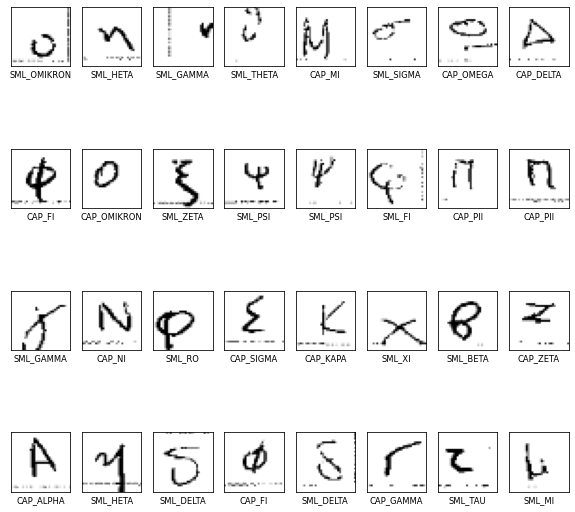

In [17]:
look_at_batch(train_dataset)

In [32]:
# optimizing using variable learning rate variable_learning_rate callback
history4 = model4.fit(train_dataset, steps_per_epoch=stps_per_epoch, epochs = EPOCHS, callbacks = [early_stopping], validation_data = val_dataset, validation_steps=int(val_dataset_size/BATCH_SIZE)+1)

Epoch 1/100
940/940 [==============================] - 24s 22ms/step - loss: 3.0479 - accuracy: 0.2054 - precision_4: 0.6144 - recall_4: 0.0343 - val_loss: 2.0467 - val_accuracy: 0.4039 - val_precision_4: 0.6787 - val_recall_4: 0.1709
Epoch 2/100
940/940 [==============================] - 21s 22ms/step - loss: 1.8463 - accuracy: 0.4710 - precision_4: 0.6860 - recall_4: 0.2535 - val_loss: 1.3154 - val_accuracy: 0.6083 - val_precision_4: 0.7452 - val_recall_4: 0.4941
Epoch 3/100
940/940 [==============================] - 20s 22ms/step - loss: 1.5149 - accuracy: 0.5615 - precision_4: 0.7158 - recall_4: 0.4055 - val_loss: 1.1662 - val_accuracy: 0.6648 - val_precision_4: 0.7785 - val_recall_4: 0.5541
Epoch 4/100
940/940 [==============================] - 21s 22ms/step - loss: 1.3630 - accuracy: 0.6087 - precision_4: 0.7462 - recall_4: 0.4798 - val_loss: 1.1548 - val_accuracy: 0.6648 - val_precision_4: 0.7790 - val_recall_4: 0.5753
Epoch 5/100
940/940 [==============================] - 20s 2

Epoch 36/100
940/940 [==============================] - 20s 21ms/step - loss: 0.8156 - accuracy: 0.7701 - precision_4: 0.8292 - recall_4: 0.7223 - val_loss: 0.8125 - val_accuracy: 0.7816 - val_precision_4: 0.8249 - val_recall_4: 0.7528
Epoch 37/100
940/940 [==============================] - 20s 21ms/step - loss: 0.8021 - accuracy: 0.7750 - precision_4: 0.8342 - recall_4: 0.7265 - val_loss: 0.8061 - val_accuracy: 0.7896 - val_precision_4: 0.8310 - val_recall_4: 0.7587
Epoch 38/100
940/940 [==============================] - 20s 21ms/step - loss: 0.8073 - accuracy: 0.7703 - precision_4: 0.8313 - recall_4: 0.7231 - val_loss: 0.7959 - val_accuracy: 0.7873 - val_precision_4: 0.8286 - val_recall_4: 0.7571
Epoch 39/100
940/940 [==============================] - 20s 21ms/step - loss: 0.7978 - accuracy: 0.7750 - precision_4: 0.8329 - recall_4: 0.7278 - val_loss: 0.8121 - val_accuracy: 0.7935 - val_precision_4: 0.8332 - val_recall_4: 0.7628
Epoch 40/100
940/940 [==============================] - 

Epoch 71/100
940/940 [==============================] - 20s 21ms/step - loss: 0.7177 - accuracy: 0.8032 - precision_4: 0.8515 - recall_4: 0.7650 - val_loss: 0.7617 - val_accuracy: 0.8032 - val_precision_4: 0.8398 - val_recall_4: 0.7812
Epoch 72/100
940/940 [==============================] - 20s 21ms/step - loss: 0.7145 - accuracy: 0.8023 - precision_4: 0.8494 - recall_4: 0.7647 - val_loss: 0.7626 - val_accuracy: 0.8085 - val_precision_4: 0.8445 - val_recall_4: 0.7830
Epoch 73/100
940/940 [==============================] - 20s 21ms/step - loss: 0.7193 - accuracy: 0.8018 - precision_4: 0.8494 - recall_4: 0.7627 - val_loss: 0.7865 - val_accuracy: 0.8021 - val_precision_4: 0.8381 - val_recall_4: 0.7782
Epoch 74/100
940/940 [==============================] - 20s 21ms/step - loss: 0.7183 - accuracy: 0.8015 - precision_4: 0.8481 - recall_4: 0.7622 - val_loss: 0.7689 - val_accuracy: 0.8028 - val_precision_4: 0.8416 - val_recall_4: 0.7816
Epoch 75/100
940/940 [==============================] - 

In [33]:
#model1.save("weights/ANN_handwritten_greek_letters_classification_"+str(EPOCHS)+".h5")
#model2.save("weights/LeNet5_handwritten_greek_letters_classification"+str(EPOCHS)+".h5")
#model3.save("weights/BetterLeNet5_handwritten_greek_letters_classification"+str(EPOCHS)+".h5")
#model4.save("weights/LeNet5v2_handwritten_greek_letters_classification"+str(EPOCHS)+".h5")

In [104]:
#model3 = tf.keras.models.load_model("weights/best_BetterLeNet5_handwritten_greek_letters_classification50.h5")

## Metrics
1. loss and accuracy for the training steps evaluated on the train set and validation set
2. loss, accuracy, precision and recall evaluated for the model using the test set
3. confusion matrices of the models' predictions on the test set

In [105]:
# training metrics (graphs)
def plot_training_metrics(history):
    """
    Function to print metrics of interest
    """
    epochs = range(len(history.history["accuracy"]))
    fig = plt.figure(figsize=(18,7))
    fig.add_subplot(1, 2, 1)
    plt.plot(epochs, history.history["loss"], color="r", label="training")
    plt.plot(epochs, history.history["val_loss"], color="b", label="validation")
    plt.title("Loss")
    plt.xlabel("epochs", size = "small")
    plt.ylabel("loss", size = "small")
    plt.legend()
    fig.add_subplot(1, 2, 2)
    plt.plot(epochs, history.history["accuracy"], color="r", label="training")
    plt.plot(epochs, history.history["val_accuracy"], color="b", label="validation")
    plt.title("Accuracy")
    plt.xlabel("epochs", size = "small")
    plt.ylabel("accuracy", size = "small")
    plt.legend()
    plt.show()

In [106]:
# function to plot the confusion matrix, taken from scikitlean website
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

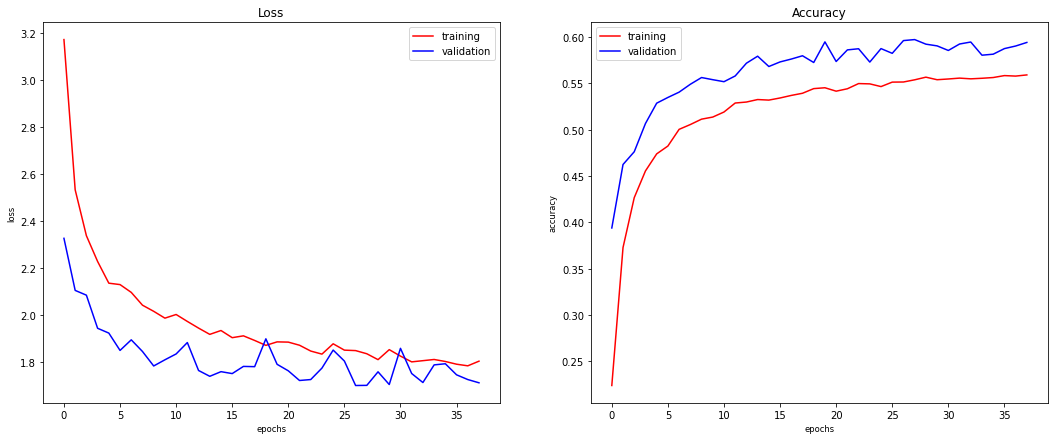

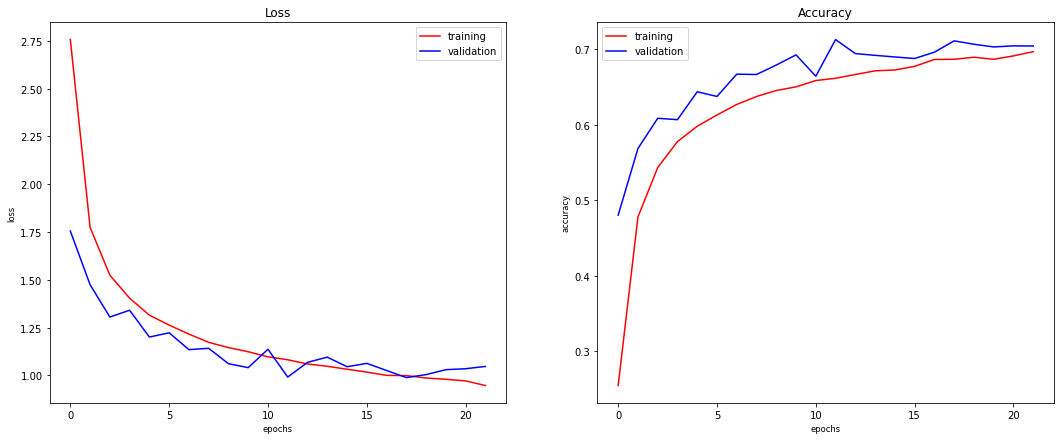

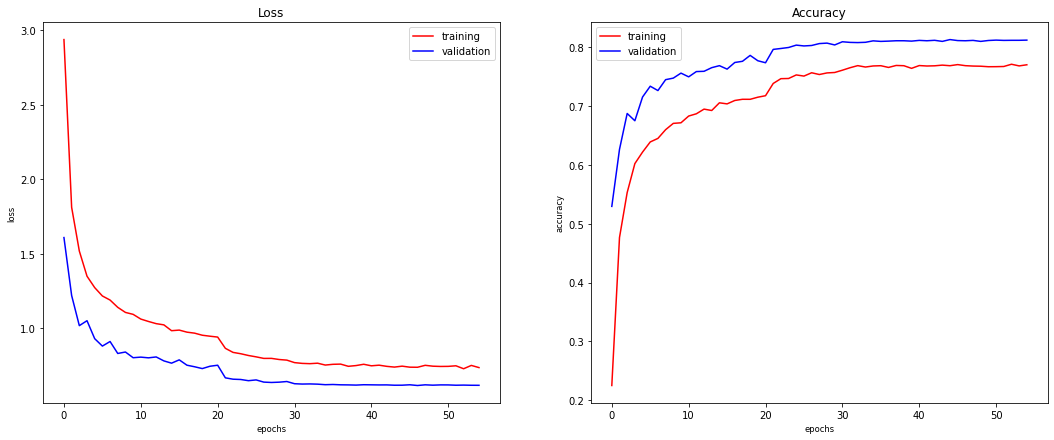

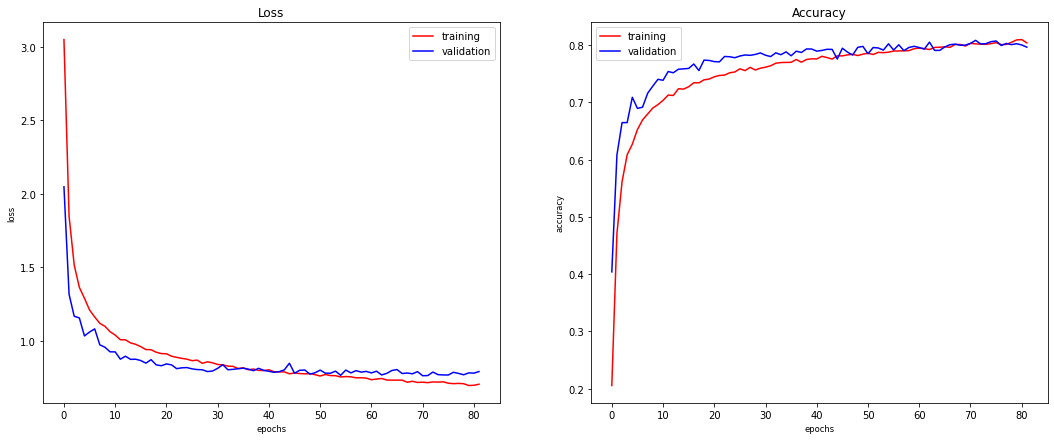

In [107]:
plot_training_metrics(history1)
plot_training_metrics(history2)
plot_training_metrics(history3)
plot_training_metrics(history4)

In [108]:
# evaluating models 
metrics1 = model1.evaluate(test_dataset, steps = int(test_dataset_size/BATCH_SIZE)+1)
metrics2 = model2.evaluate(test_dataset, steps = int(test_dataset_size/BATCH_SIZE)+1)
metrics3 = model3.evaluate(test_dataset, steps = int(test_dataset_size/BATCH_SIZE)+1)
metrics4 = model4.evaluate(test_dataset, steps = int(test_dataset_size/BATCH_SIZE)+1)

202/202 [==============================] - 2s 8ms/step - loss: 0.7373 - accuracy: 0.8049 - precision_4: 0.8419 - recall_4: 0.7823


In [109]:
# evaluation metrics (tables of precision, recall, accuracy, loss and confusion matrices)
# table of precision, recall, accuracy, loss
print("{:<15} {:<10} {:<10} {:<10} {:<10}".format("Model", "Loss", "Accuracy", "Precision", "Recall"))
print("{:<15} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f}".format(model1._name, metrics1[0], metrics1[1], metrics1[2], metrics1[3]))
print("{:<15} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f}".format(model2._name, metrics2[0], metrics2[1], metrics2[2], metrics2[3]))
print("{:<15} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f}".format(model3._name, metrics3[0], metrics3[1], metrics3[2], metrics3[3]))
print("{:<15} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f}".format(model4._name, metrics4[0], metrics4[1], metrics4[2], metrics4[3]))

Model           Loss       Accuracy   Precision  Recall    
ANN             1.492      0.622      0.712      0.545     
LeNet5          0.901      0.726      0.784      0.689     
BetterLeNet5    0.400      0.880      0.903      0.861     
LeNet5v2        0.737      0.805      0.842      0.782     


In [110]:
def predict_lab_pred(model):
    n_batches = test_dataset_size/BATCH_SIZE
    i=0
    predictions = np.array([])
    labels = np.array([])
    for batch in test_dataset:
        if(i > n_batches):
            break
        predictions_batch = model.predict(batch[0], verbose = "silent")
        predictions = np.append(predictions, np.argmax(predictions_batch, axis = 1))
        labels = np.append(labels, np.argmax(batch[1], axis = 1))
        i = i + 1
    return predictions, labels

In [111]:
predictions1, labels1 = predict_lab_pred(model1)
predictions2, labels2 = predict_lab_pred(model2)
predictions3, labels3 = predict_lab_pred(model3)
predictions4, labels4 = predict_lab_pred(model4)

Confusion matrix, without normalization
[[ 30   5   1 ...   1   0   3]
 [  0 113   0 ...   1   0   0]
 [  1   0  99 ...   0   1   0]
 ...
 [  3   2   0 ...  84   0   5]
 [  0   0   1 ...   0  76   4]
 [  0   0   0 ...   1   0 100]]


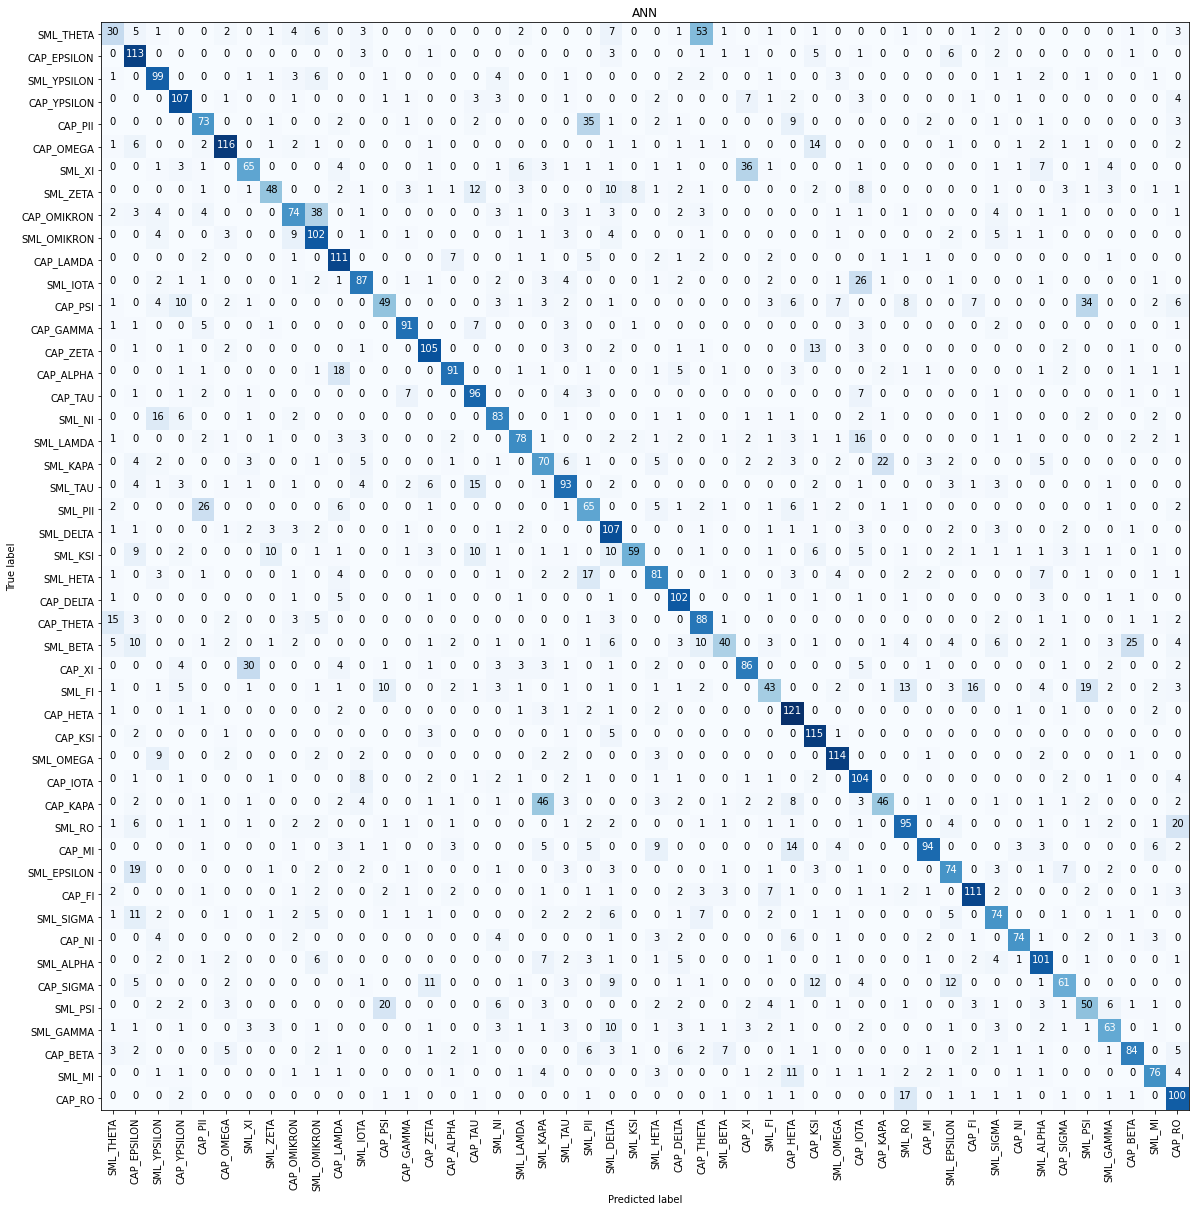

In [112]:
cm = confusion_matrix(labels1, predictions1)
plot_confusion_matrix(cm=cm, classes=CATEGORIES, title="ANN")

Confusion matrix, without normalization
[[ 31   0   0 ...   2   0   0]
 [  0 110   0 ...   1   0   0]
 [  0   0 110 ...   0   0   0]
 ...
 [  4   2   0 ... 113   0   0]
 [  0   0   0 ...   0  86   0]
 [  1   0   0 ...   0   0  80]]


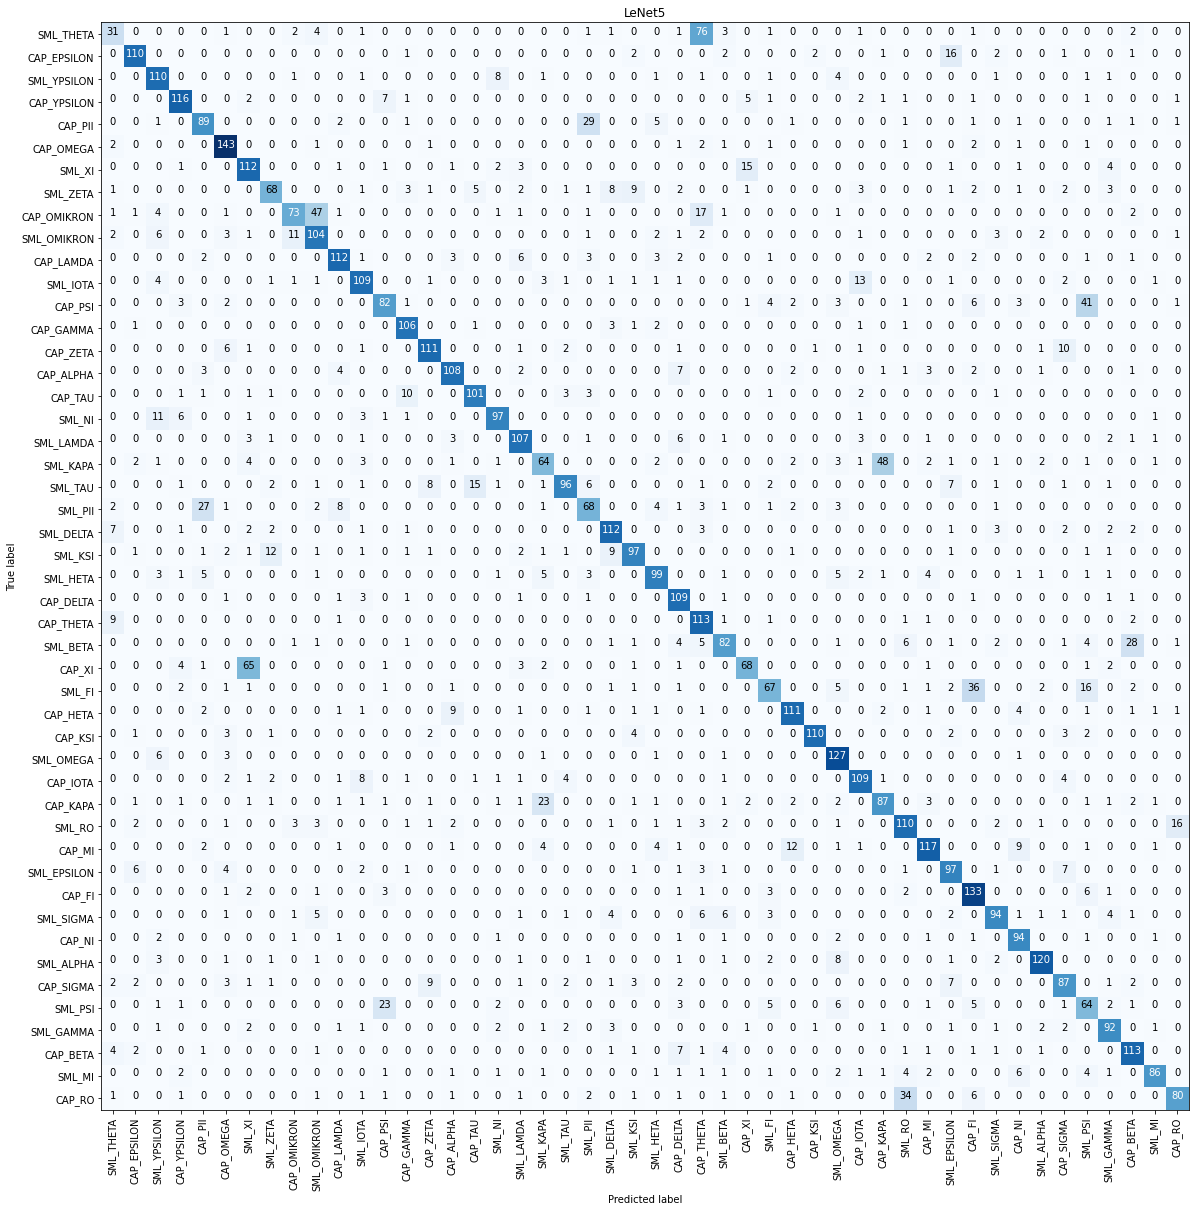

In [113]:
cm = confusion_matrix(labels2, predictions2)
plot_confusion_matrix(cm=cm, classes=CATEGORIES, title="LeNet5")

Confusion matrix, without normalization
[[ 80   0   0 ...   0   0   0]
 [  0 132   0 ...   1   0   0]
 [  0   0 124 ...   0   0   0]
 ...
 [  0   0   0 ... 132   0   0]
 [  0   0   0 ...   0 112   0]
 [  0   0   0 ...   0   0 108]]


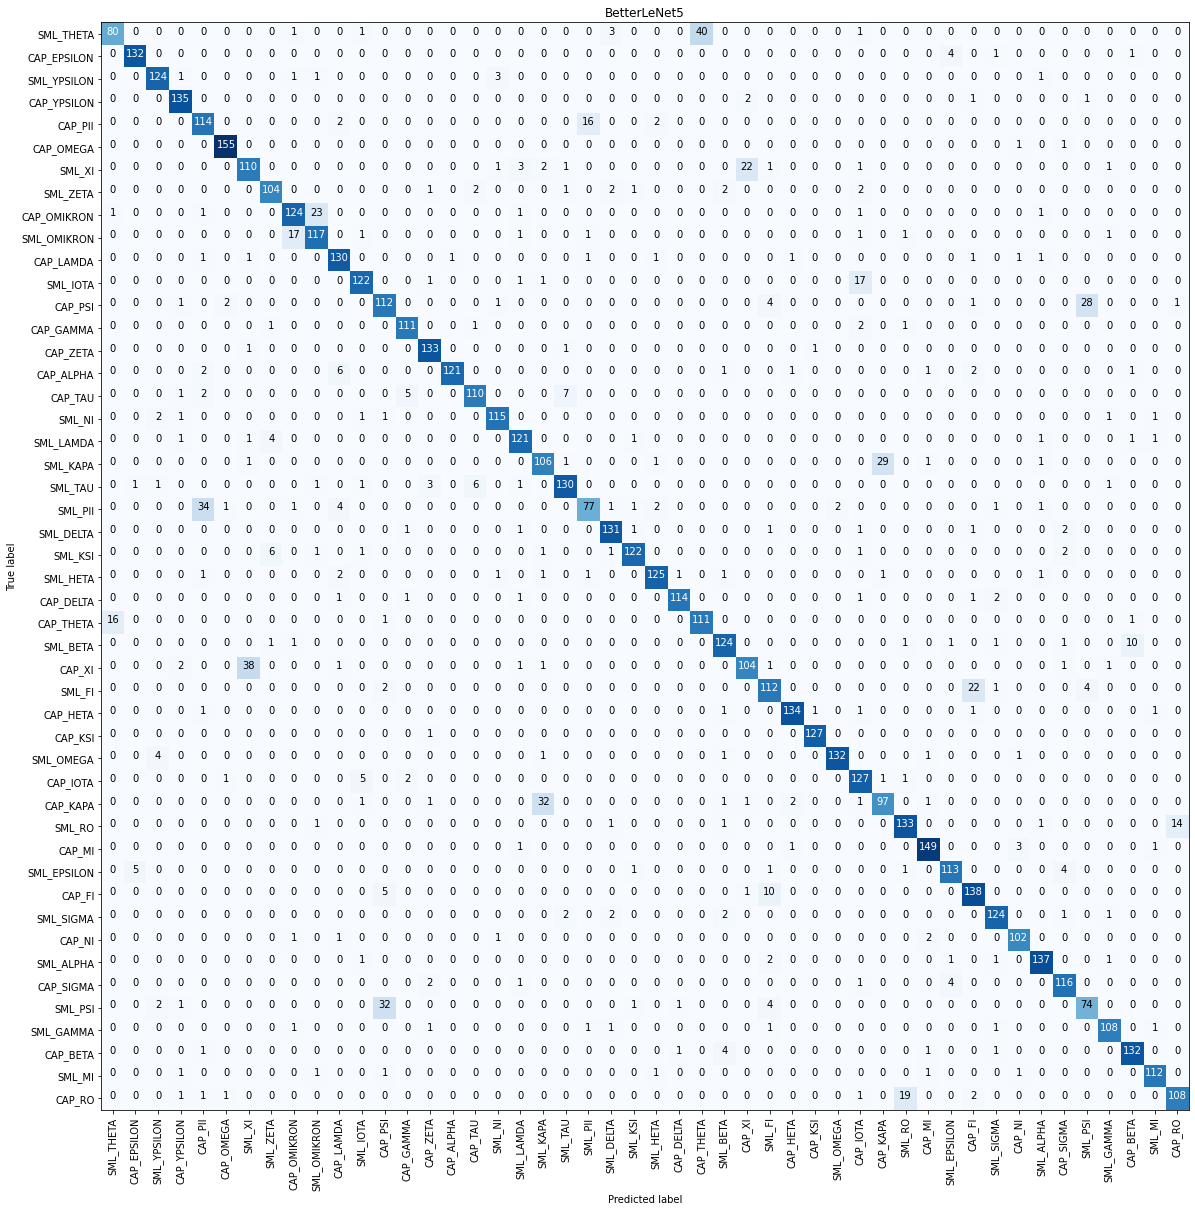

In [114]:
cm = confusion_matrix(labels3, predictions3) 
plot_confusion_matrix(cm=cm, classes=CATEGORIES, title="BetterLeNet5")

Confusion matrix, without normalization
[[ 66   1   0 ...   0   0   0]
 [  0 126   0 ...   1   0   0]
 [  0   0 118 ...   0   0   0]
 ...
 [  0   0   0 ... 122   0   0]
 [  0   0   0 ...   0 103   0]
 [  0   0   0 ...   0   1  94]]


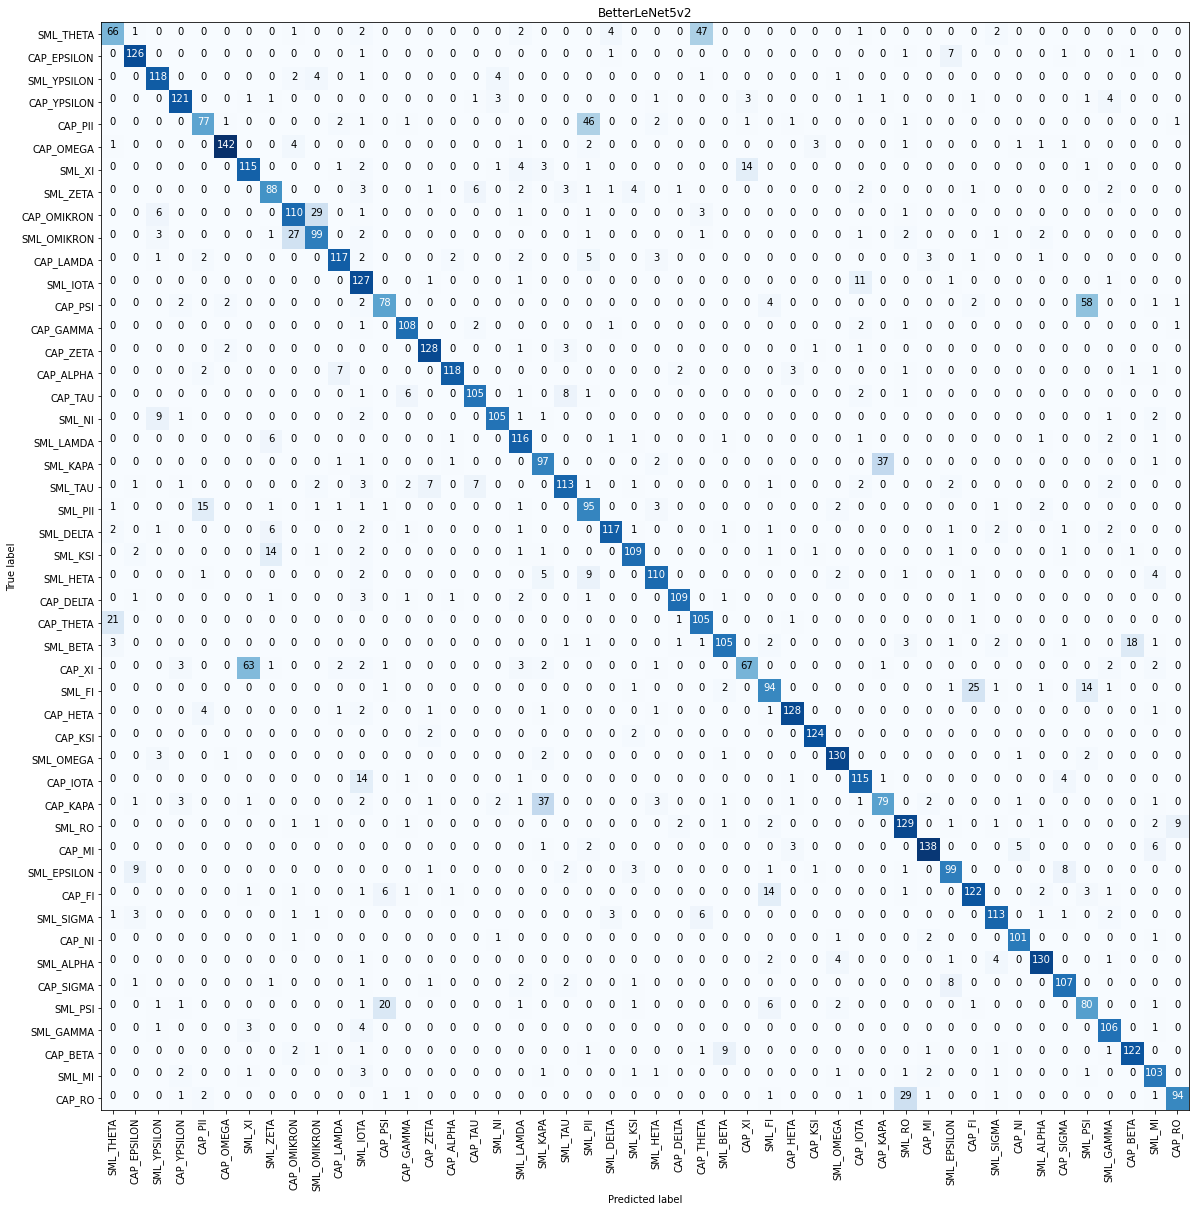

In [115]:
cm = confusion_matrix(labels4, predictions4) 
plot_confusion_matrix(cm=cm, classes=CATEGORIES, title="BetterLeNet5v2")

### Merging some classes

In [116]:
def change_categories(categories, new_categories, removed_categories, labels):
    """
    Function used to merge some categories. Removed categories are always SML_
    and are merged into CAP_
    """
    new_labels = []
    for e in labels:
        label = categories[e]
        if label in removed_categories:
            # change accordingly
            label = "CAP_" + label[4:]
        i = new_categories.index(label)
        new_labels.append(i)
    return np.array(new_labels)

In [117]:
# utility functions to compute precision, recall and accuracy from a confusion matrix
def precision(cm):
    """
    Average precision for all classes
    """
    n_classes = len(cm)
    p = 0
    for i in range(len(cm[0])):
        tot = 0
        tp = 0
        for j in range(len(cm)):
            if(i == j):
                tp = cm[j][i]
            tot += cm[j][i]
        p += (tp/tot) / n_classes
    return p
def recall(cm):
    """
    Average recall for all classes
    """
    n_classes = len(cm)
    r = 0
    for i in range(len(cm)):
        tot = 0
        tp = 0
        for j in range(len(cm[0])):
            if(i == j):
                tp = cm[i][j]
            tot += cm[i][j]
        r += (tp/tot) / n_classes
    return r
def accuracy(cm):
    """
    Accuracy computed as the ratio of number of true positives and number of total classifications
    """
    tp = 0
    tot = 0
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            if(i == j):
                tp += cm[i][j]
            tot += cm[i][j]
    return tp/tot

In [118]:
# trying merging some almost undistinguishable classes
# this was also done by Stamatopoulos, Pratikakis and Perantonis
CATEGORIES_TO_MERGE = ["SML_THETA", "SML_PII", "SML_XI", "SML_OMIKRON", "SML_IOTA", "SML_PSI", "SML_TAU", "SML_KAPA", "SML_RO", "SML_FI", "SML_BETA"]
NEW_CATEGORIES = [x for x in CATEGORIES if x not in CATEGORIES_TO_MERGE]

labels1_merged = change_categories(CATEGORIES, NEW_CATEGORIES, CATEGORIES_TO_MERGE, labels1.astype(np.int32))
predictions1_merged = change_categories(CATEGORIES, NEW_CATEGORIES, CATEGORIES_TO_MERGE, predictions1.astype(np.int32))

labels2_merged = change_categories(CATEGORIES, NEW_CATEGORIES, CATEGORIES_TO_MERGE, labels2.astype(np.int32))
predictions2_merged = change_categories(CATEGORIES, NEW_CATEGORIES, CATEGORIES_TO_MERGE, predictions2.astype(np.int32))

labels3_merged = change_categories(CATEGORIES, NEW_CATEGORIES, CATEGORIES_TO_MERGE, labels3.astype(np.int32))
predictions3_merged = change_categories(CATEGORIES, NEW_CATEGORIES, CATEGORIES_TO_MERGE, predictions3.astype(np.int32))

labels4_merged = change_categories(CATEGORIES, NEW_CATEGORIES, CATEGORIES_TO_MERGE, labels4.astype(np.int32))
predictions4_merged = change_categories(CATEGORIES, NEW_CATEGORIES, CATEGORIES_TO_MERGE, predictions4.astype(np.int32))

In [119]:
cm1 = confusion_matrix(labels1_merged, predictions1_merged) 
cm2 = confusion_matrix(labels2_merged, predictions2_merged) 
cm3 = confusion_matrix(labels3_merged, predictions3_merged)
cm4 = confusion_matrix(labels4_merged, predictions4_merged)

In [120]:
metrics1 = [accuracy(cm1), precision(cm1), recall(cm1)]
metrics2 = [accuracy(cm2), precision(cm2), recall(cm2)]
metrics3 = [accuracy(cm3), precision(cm3), recall(cm3)]
metrics4 = [accuracy(cm4), precision(cm4), recall(cm4)]

In [121]:
print("{:<20} {:<10} {:<10} {:<10}".format("Model", "Accuracy", "Precision", "Recall"))
print("{:<20} {:<10.3f} {:<10.3f} {:<10.3f}".format(model1._name, metrics1[0], metrics1[1], metrics1[2]))
print("{:<20} {:<10.3f} {:<10.3f} {:<10.3f}".format(model2._name, metrics2[0], metrics2[1], metrics2[2]))
print("{:<20} {:<10.3f} {:<10.3f} {:<10.3f}".format(model3._name, metrics3[0], metrics3[1], metrics3[2]))
print("{:<20} {:<10.3f} {:<10.3f} {:<10.3f}".format(model4._name, metrics4[0], metrics4[1], metrics4[2]))

Model                Accuracy   Precision  Recall    
ANN                  0.699      0.700      0.694     
LeNet5               0.815      0.810      0.810     
BetterLeNet5         0.948      0.946      0.946     
LeNet5v2             0.892      0.888      0.888     


Confusion matrix, without normalization
[[132   0   0 ...   1   0   0]
 [  0 124   1 ...   0   0   0]
 [  0   0 135 ...   0   0   0]
 ...
 [  0   0   0 ... 270   0   1]
 [  0   0   1 ...   0 112   0]
 [  0   0   1 ...   1   0 274]]


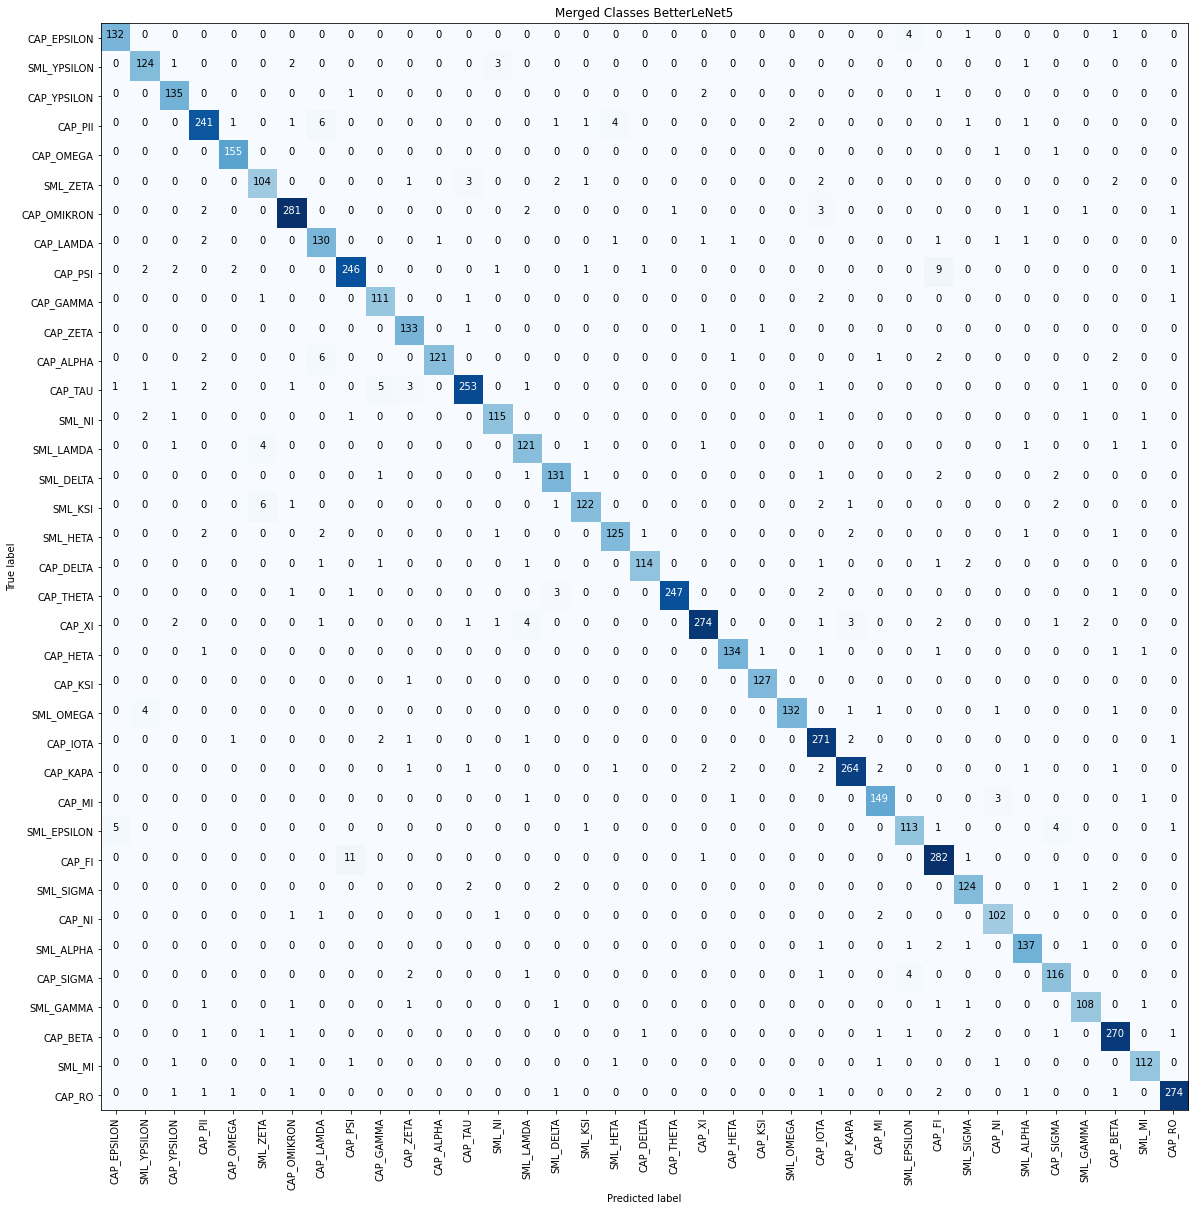

In [122]:
# we should find that the most common errors are
# CAP_PSI <-> CAP_FI; SML_ZETA <-> SML_KSI;
# SML_NI <-> SML_YPSILON; SML_HETA <-> SML_PII; SML_GAMMA <-> CAP_XI;
cm3 = confusion_matrix(labels3_merged, predictions3_merged) 
plot_confusion_matrix(cm=cm3, classes=NEW_CATEGORIES, title="Merged Classes BetterLeNet5")

Confusion matrix, without normalization
[[126   0   0 ...   1   0   1]
 [  0 118   0 ...   0   0   0]
 [  0   0 121 ...   0   0   0]
 ...
 [  0   0   0 ... 254   1   3]
 [  0   0   2 ...   0 103   1]
 [  0   0   1 ...   1   3 261]]


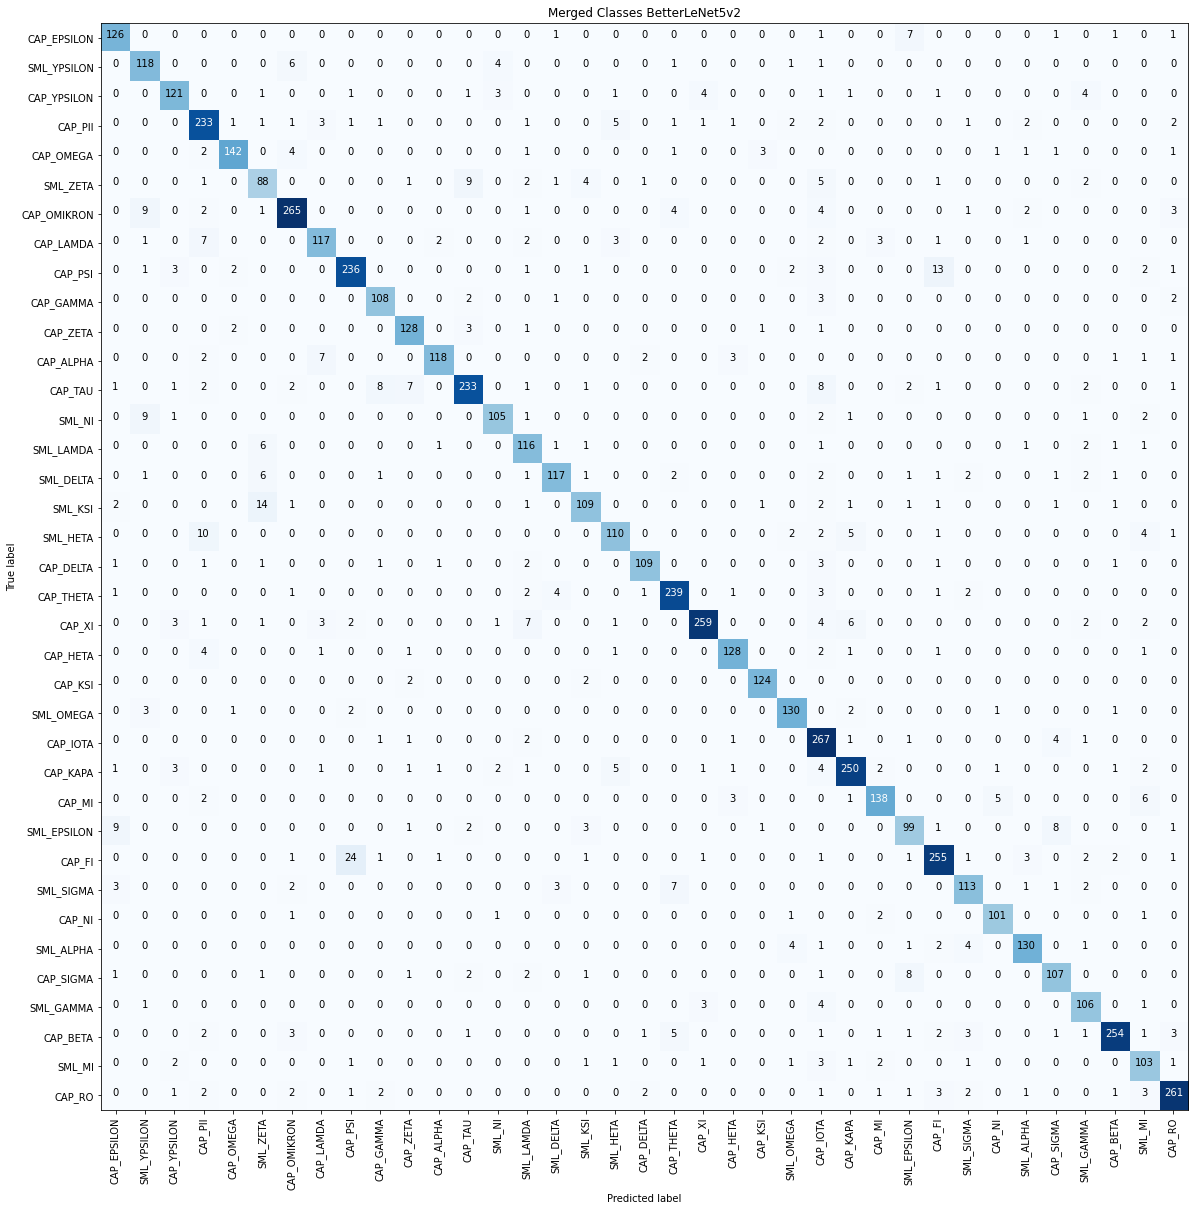

In [123]:
cm4 = confusion_matrix(labels4_merged, predictions4_merged) 
plot_confusion_matrix(cm=cm4, classes=NEW_CATEGORIES, title="Merged Classes BetterLeNet5v2")

1/1 [==============================] - 0s 21ms/step


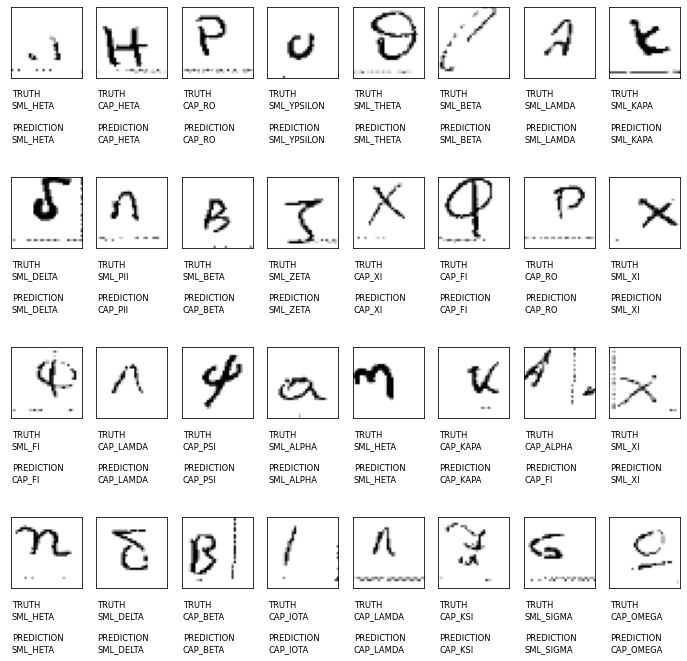

In [124]:
# example of predictions with BetterLeNet5
for batch in test_dataset:
    results = model3.predict(batch[0])
    results = np.argmax(results, axis = 1)
    fig = plt.figure(figsize=(12,12))
    rows = 4
    cols = 8
    for i in range(BATCH_SIZE):
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(batch[0][i],cmap="gray")
        indx = np.where(batch[1][i]==1)[0][0]
        plt.text(0, 40,"TRUTH",size="small")
        plt.text(0, 45,CATEGORIES[indx],size="small")
        plt.text(0, 55,"PREDICTION",size="small")
        plt.text(0, 60,CATEGORIES[results[i]],size="small")
        plt.xticks([])
        plt.yticks([])
    plt.show()
    break